In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#%cd /content/drive/MyDrive/서울대학교/research_2024/ML
#!unzip "data_240610.zip"

Mounted at /content/drive


In [ ]:
import os
import pickle
import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

##############################
### hyperparameters
#dataset_root_dir = "data"
#output_save_dir = "output"
dataset_root_dir = "/content/drive/MyDrive/SNU/research_2024/ML/data"
dataset_aug_dir = "/content/drive/MyDrive/SNU/research_2024/ML/data_aug"
output_save_dir = "/content/drive/MyDrive/SNU/research_2024/ML/output"
#dataset_root_dir = dataset_aug_dir
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda"

# for preprocessing
theta_phi_normalizer_str = 'MinMaxScaler'
redshift_mass_dist_normalizer_str = 'QuantileTransformer'

# for model
layer_dim1 = 12
layer_dim2 = 7
latent_dim = 2

# for training
num_epochs = 30
#batch_size = 2
optimizer_str = 'Adam'
lr = 0.001 # learning rate

# for loss
margin = 0.05
lambda_recon = 1.0
lambda_z_reg = 1.0
##############################

class FoFDataset(Dataset):
    def __init__(self, data, label, dist):
        self.data = [torch.tensor(data[idx]).float() for idx in range(len(data))]
        self.label = [torch.tensor(label[idx]).float() for idx in range(len(label))]
        self.dist = [torch.tensor(dist[idx]).float() for idx in range(len(dist))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx], self.dist[idx]

    def shuffle(self):
        perm_idx_list = torch.randperm(len(self.data))
        self.data = [self.data[perm_idx] for perm_idx in perm_idx_list]
        self.label = [self.label[perm_idx] for perm_idx in perm_idx_list]
        self.dist = [self.dist[perm_idx] for perm_idx in perm_idx_list]

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, layer_dim1, layer_dim2, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer_dim1),
            nn.ReLU(),
            nn.Linear(layer_dim1, layer_dim2),
            nn.ReLU(),
            nn.Linear(layer_dim2, latent_dim)
        )
        self.recon_head = nn.Sequential(
            nn.Linear(latent_dim, layer_dim2),
            nn.ReLU(),
            nn.Linear(layer_dim2, layer_dim1),
            nn.ReLU(),
            nn.Linear(layer_dim1, input_dim),
        )
        self.z_reg_head = nn.Sequential(
            nn.Linear(latent_dim, layer_dim2),
            nn.ReLU(),
            nn.Linear(layer_dim2, layer_dim1),
            nn.ReLU(),
            nn.Linear(layer_dim1, 1),
		)


    def forward(self, x, return_latent_only=False):
        latent = self.encoder(x)
        if return_latent_only:
            return latent

        recon_out = self.recon_head(latent)
        z_out = self.z_reg_head(latent)
        return recon_out, z_out, latent


def load_pkl_dir_list(pkl_dir_list):
    # total variables: list(theta_piece), list(phi_piece), list(z_obs_piece), list(masses_piece), list(r_piece), Nfof, list(labels), cng
    input_list, label_list, dist_list = [], [], []
    for pkl_dir in pkl_dir_list:
        _, _, _, mass, dist, _, label, _, _, redshift, theta, phi  = pickle.load(open(pkl_dir, "rb")) #redshift, theta, phi = x,y,z
#        theta, phi, redshift, mass, dist, _, label, _, _, _, _, _  = pickle.load(open(pkl_dir, "rb"))
        input_list.append(list(zip(theta, phi, redshift, np.log10(mass))))
        label_list.append(np.expand_dims(np.array(label), axis=-1))
        dist_list.append(np.expand_dims(np.array(dist), axis=-1))
        #print(f"{torch.unique(torch.tensor(label))=}")
    return input_list, label_list, dist_list


def get_normalizer(train_input_list, val_input_list, train_dist_list, val_dist_list):
    train_val_redshift_mass = np.concatenate([np.concatenate(train_input_list), np.concatenate(val_input_list)])[:, 2:4]
    train_val_dist = np.concatenate([np.concatenate(train_dist_list), np.concatenate(val_dist_list)])
    # redshift: quantile normalization
    # mass: quantile normalization for log values
    # dist: quantile normalization
    redshift_mass_preprocessor = getattr(sklearn.preprocessing, redshift_mass_dist_normalizer_str)().fit(train_val_redshift_mass)
    dist_preprocessor = getattr(sklearn.preprocessing, redshift_mass_dist_normalizer_str)().fit(train_val_dist)
    return redshift_mass_preprocessor, dist_preprocessor


def normalize(input_list, dist_list, normalizer_dict):
    normalized_input_list, normalized_dist_list = [], []
    for i in range(len(input_list)):
        input = input_list[i]
        input = pd.DataFrame(input, columns=["theta", "phi", "redshift", "mass"])
        # theta, phi: minmax normalization for each piece
        input[["theta", "phi"]] = getattr(sklearn.preprocessing, theta_phi_normalizer_str)().fit_transform(input[["theta", "phi"]])
        input[["redshift", "mass"]] = normalizer_dict["redshift_mass"].transform(input[["redshift", "mass"]])
        normalized_input_list.append(input.to_numpy())

        dist = dist_list[i]
        dist = normalizer_dict["dist"].transform(np.array(dist))
        normalized_dist_list.append(dist)
    return normalized_input_list, normalized_dist_list


def margin_loss_fn(latent, labels, margin):
    distances = torch.cdist(latent, latent, p=2)
    label_matrix = (labels == labels.T).float()
    pos_loss = label_matrix * torch.pow(distances, 2)
    neg_loss = (1 - label_matrix) * torch.pow(torch.clamp(margin - distances, min=0.0), 2)
    loss = torch.mean(pos_loss + neg_loss) / 2.0
    return loss


def plot_train_val(train_loss_history, val_loss_history):
    plt.plot(train_loss_history)
    plt.plot(np.array(val_loss_history)*100)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('train val loss curve')
    plt.legend(['train', '100*val'])
    plt.savefig(os.path.join(output_save_dir, "loss_curve_240617_ra_dec_z.png"))

In [ ]:
#Preprocess
#~3m
pkl_dir_list = [os.path.join(dataset_root_dir, dir) for dir in os.listdir(dataset_root_dir)]
train_pkl_dir_list, test_pkl_dir_list = train_test_split(pkl_dir_list, test_size=0.2, random_state=42)
train_pkl_dir_list, val_pkl_dir_list = train_test_split(train_pkl_dir_list, test_size=0.25, random_state=42)

train_input_list, train_label_list, train_dist_list = load_pkl_dir_list(train_pkl_dir_list)
val_input_list, val_label_list, val_dist_list = load_pkl_dir_list(val_pkl_dir_list)
test_input_list, test_label_list, test_dist_list = load_pkl_dir_list(test_pkl_dir_list)

In [ ]:
len(train_input_list)

1500

In [ ]:
redshift_mass_normalizer, dist_normalizer = get_normalizer(train_input_list, val_input_list, train_dist_list, val_dist_list)
normalizer_dict = {"redshift_mass": redshift_mass_normalizer, "dist": dist_normalizer}
train_input_list, train_dist_list = normalize(train_input_list, train_dist_list, normalizer_dict)
val_input_list, val_dist_list = normalize(val_input_list, val_dist_list, normalizer_dict)
test_input_list, test_dist_list = normalize(test_input_list, test_dist_list, normalizer_dict)

train_dataset = FoFDataset(train_input_list, train_label_list, train_dist_list)
val_dataset = FoFDataset(val_input_list, val_label_list, val_dist_list)
test_dataset = FoFDataset(test_input_list, test_label_list, test_dist_list)

In [ ]:
#from torch.utils.data import DataLoader
#train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
#test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#print(len(train_dataset))
#print(len(train_loader))

1500
375


val: 100%|██████████| 500/500 [00:22<00:00, 22.53it/s]


epoch [1/30] train loss: 0.068974 val loss: 0.000023


val: 100%|██████████| 500/500 [00:22<00:00, 22.54it/s]


epoch [2/30] train loss: 0.041611 val loss: 0.000014


val: 100%|██████████| 500/500 [00:22<00:00, 22.56it/s]


epoch [3/30] train loss: 0.041592 val loss: 0.000008


val: 100%|██████████| 500/500 [00:22<00:00, 22.57it/s]


epoch [4/30] train loss: 0.041579 val loss: 0.000006


val: 100%|██████████| 500/500 [00:22<00:00, 22.60it/s]


epoch [5/30] train loss: 0.041559 val loss: 0.000006


val: 100%|██████████| 500/500 [00:22<00:00, 22.60it/s]


epoch [6/30] train loss: 0.041381 val loss: 0.000010


val: 100%|██████████| 500/500 [00:22<00:00, 22.59it/s]


epoch [7/30] train loss: 0.041210 val loss: 0.000013


val: 100%|██████████| 500/500 [00:22<00:00, 22.60it/s]


epoch [8/30] train loss: 0.041136 val loss: 0.000014


val: 100%|██████████| 500/500 [00:22<00:00, 22.59it/s]


epoch [9/30] train loss: 0.041082 val loss: 0.000014


val: 100%|██████████| 500/500 [00:22<00:00, 22.59it/s]


epoch [10/30] train loss: 0.039799 val loss: 0.000029


val: 100%|██████████| 500/500 [00:22<00:00, 22.58it/s]


epoch [11/30] train loss: 0.036610 val loss: 0.000039


val: 100%|██████████| 500/500 [00:22<00:00, 22.58it/s]


epoch [12/30] train loss: 0.034852 val loss: 0.000069


val: 100%|██████████| 500/500 [00:22<00:00, 22.64it/s]


epoch [13/30] train loss: 0.033650 val loss: 0.000059


val: 100%|██████████| 500/500 [00:22<00:00, 22.64it/s]


epoch [14/30] train loss: 0.032944 val loss: 0.000054


val: 100%|██████████| 500/500 [00:22<00:00, 22.64it/s]


epoch [15/30] train loss: 0.032578 val loss: 0.000052


val: 100%|██████████| 500/500 [00:22<00:00, 22.64it/s]


epoch [16/30] train loss: 0.032377 val loss: 0.000063


val: 100%|██████████| 500/500 [00:22<00:00, 22.65it/s]


epoch [17/30] train loss: 0.032260 val loss: 0.000066


val: 100%|██████████| 500/500 [00:22<00:00, 22.62it/s]


epoch [18/30] train loss: 0.031888 val loss: 0.000068


val: 100%|██████████| 500/500 [00:22<00:00, 22.65it/s]


epoch [19/30] train loss: 0.031249 val loss: 0.000071


val: 100%|██████████| 500/500 [00:22<00:00, 22.64it/s]


epoch [20/30] train loss: 0.031046 val loss: 0.000071


val: 100%|██████████| 500/500 [00:22<00:00, 22.52it/s]


epoch [21/30] train loss: 0.030985 val loss: 0.000061


val: 100%|██████████| 500/500 [00:22<00:00, 22.35it/s]


epoch [22/30] train loss: 0.030928 val loss: 0.000062


val: 100%|██████████| 500/500 [00:22<00:00, 22.35it/s]


epoch [23/30] train loss: 0.030895 val loss: 0.000059


val: 100%|██████████| 500/500 [00:22<00:00, 22.51it/s]


epoch [24/30] train loss: 0.030854 val loss: 0.000055


val: 100%|██████████| 500/500 [00:22<00:00, 22.56it/s]


epoch [25/30] train loss: 0.030824 val loss: 0.000048


val: 100%|██████████| 500/500 [00:22<00:00, 22.54it/s]


epoch [26/30] train loss: 0.030792 val loss: 0.000047


val: 100%|██████████| 500/500 [00:22<00:00, 22.56it/s]


epoch [27/30] train loss: 0.030755 val loss: 0.000039


val: 100%|██████████| 500/500 [00:22<00:00, 22.46it/s]


epoch [28/30] train loss: 0.030718 val loss: 0.000035


val: 100%|██████████| 500/500 [00:22<00:00, 22.43it/s]


epoch [29/30] train loss: 0.030672 val loss: 0.000029


val: 100%|██████████| 500/500 [00:22<00:00, 22.51it/s]


epoch [30/30] train loss: 0.030292 val loss: 0.000024


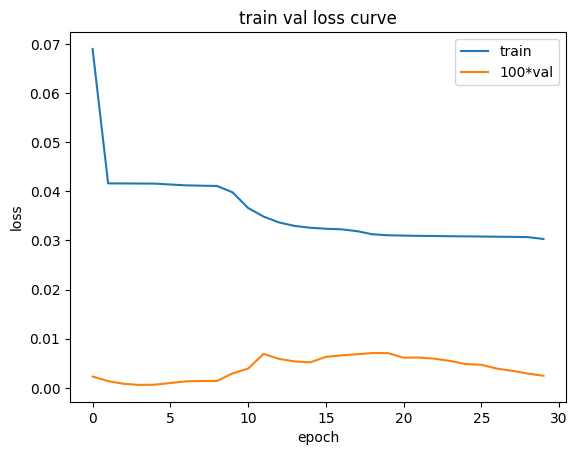

In [ ]:
model = AutoEncoder(
    input_dim=train_dataset.data[0].shape[-1],
    layer_dim1=layer_dim1,
    layer_dim2=layer_dim2,
    latent_dim=latent_dim,
).to(device)
optimizer = getattr(torch.optim, optimizer_str)(model.parameters(), lr=lr)

best_val_loss = float('inf')
best_model = None
train_loss_history, val_loss_history = [], []

for epoch in range(num_epochs):
    total_train_loss, num_train_samples = 0, 0
    train_dataset.shuffle()
    model.train()
    for idx in tqdm(range(len(train_dataset)),  desc='train'):
        inputs, labels, dists = train_dataset[idx]
        inputs, labels, dists = inputs.to(device), labels.to(device), dists.to(device)

        recon_out, z_out, latent = model(inputs)

        loss_margin = margin_loss_fn(latent, labels, margin)
        loss_recon = F.mse_loss(recon_out, inputs)
        loss_z_reg = F.mse_loss(z_out, dists)
        loss = loss_margin + lambda_recon * loss_recon + lambda_z_reg * loss_z_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * len(inputs)
        num_train_samples += len(inputs)
    total_train_loss /= num_train_samples

    total_val_loss, num_val_samples = 0, 0
    model.eval()
    for idx in tqdm(range(len(val_dataset)),  desc='val'):
        inputs, labels, dists = val_dataset[idx]
        inputs, labels, dists = inputs.to(device), labels.to(device), dists.to(device)

        latent = model(inputs, return_latent_only=True)
        loss = margin_loss_fn(latent, labels, margin)

        total_val_loss += loss.item() * len(inputs)
        num_val_samples += len(inputs)
    total_val_loss /= num_val_samples

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_model = copy.deepcopy(model)
        torch.save(model.state_dict(), os.path.join(output_save_dir, 'best_model_240617_ra_dec_z.pth'))

    last_model = copy.deepcopy(model)
    torch.save(model.state_dict(), os.path.join(output_save_dir, 'last_model_240617_ra_dec_z.pth'))


    train_loss_history.append(total_train_loss)
    val_loss_history.append(total_val_loss)

    print(f'epoch [{epoch + 1}/{num_epochs}] train loss: {total_train_loss:.6f} val loss: {total_val_loss:.6f}')

plot_train_val(train_loss_history, val_loss_history)

with open(output_save_dir+'/loss_history_ra_dec_z.pkl', 'wb') as file:
    # Step 4: Serialize the list and save it to the file
    pickle.dump([train_loss_history, val_loss_history], file)

In [ ]:
#Inference and Evaluation
# calculating the distances between members and clusters
import sklearn.cluster
#from scipy.spatial.distance import pdist

#model = AutoEncoder(
#    input_dim=train_dataset.data[0].shape[-1],
#    layer_dim=layer_dim,
#    latent_dim=latent_dim,
#).to(device)

model = AutoEncoder(
    input_dim=train_dataset.data[0].shape[-1],
    layer_dim1=layer_dim1,
    layer_dim2=layer_dim2,
    latent_dim=latent_dim,
).to(device)
optimizer = getattr(torch.optim, optimizer_str)(model.parameters(), lr=lr)

model.load_state_dict(torch.load(os.path.join(output_save_dir, 'best_model_240617_fiducial_aug.pth')))
model.eval()

##############################
### hyperparameters
clustering_str = "AgglomerativeClustering"
##############################

#total_test_loss_list, num_test_samples_list = [], []
#ground_truth_label_list, estimated_label_list = [], []
mem_dists = []
mem_dists_err = []
cl_dists = []
cl_dists_err = []
mean_alls = []
for idx in tqdm(range(len(test_dataset)),  desc='test'):
    inputs, labels, dists = test_dataset[idx]
    inputs, labels, dists = inputs.to(device), labels.to(device), dists.to(device)

    #latent = model(inputs, return_latent_only=True)
    recon_out, z_out, latent = model(inputs)
    loss = margin_loss_fn(latent, labels, margin)

    latent = latent.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy().squeeze(1)
    all = np.array(list(zip(latent[:,0], latent[:,1])))
    mean_alls.append(np.mean(np.linalg.norm(all - np.median(all, axis = 0), axis=1)))
    cng = np.array([len(labels[labels==i]) for i in range(int(max(labels)))])
    cl_ids = np.where(cng>5)[0]
    mean_mem_dists = []
    cl_cens = []
    for cl_id in cl_ids:
      cluster = np.array(list(zip(latent[:,0][labels.squeeze() == cl_id], latent[:,1][labels.squeeze() == cl_id])))
      #pairwise_distances = pdist(cluster)
      cl_cen = np.median(cluster, axis=0)
      cl_cens.append(cl_cen)
      mean_mem_dists.append(np.mean(np.linalg.norm(cluster - cl_cen, axis=1)))
    mem_dists.append(np.average(mean_mem_dists))
    mem_dists_err.append(np.std(mean_mem_dists))

    dists = np.linalg.norm(np.array(cl_cens) - np.median(cl_cens), axis=1)
    cl_dists.append(np.average(dists))
    cl_dists_err.append(np.std(dists))
    #clustering = getattr(sklearn.cluster, clustering_str)(
    #    distance_threshold=margin, n_clusters=None, metric='l2', linkage='single'
    #)
    #clustering.fit(latent)
    #estimated_labels = clustering.labels_

    #total_test_loss_list.append(loss.item() * len(inputs))
    #num_test_samples_list.append(len(inputs))
    #ground_truth_label_list.append(labels)
    #estimated_label_list.append(estimated_labels)

test: 100%|██████████| 500/500 [00:53<00:00,  9.35it/s]


In [ ]:
print('mean all')
print(np.median(mean_alls))
print(np.std(mean_alls))
print('cl mem')
print(np.median(mem_dists))
print(np.std(mem_dists))
print('cl cen')
print(np.median(cl_dists))
print(np.std(cl_dists))
#plt.hist(mean_alls)

mean all
0.76025784
0.071954526
cl mem
0.038655996
0.0025535778
cl cen
0.7766032
0.13075185


mean all
0.33251724
0.12704942
cl mem
0.008532441
0.0040070224
cl cen
0.31749514
0.124780916


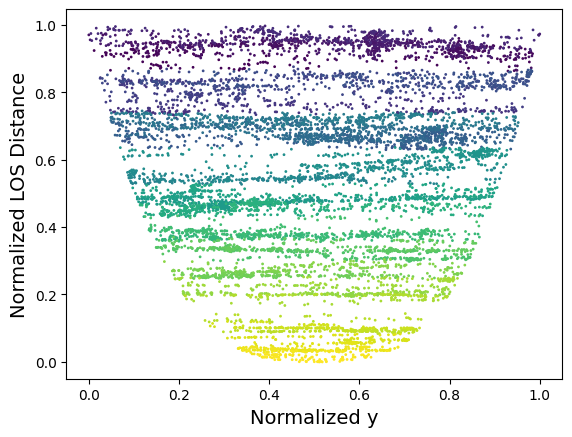

In [ ]:
#input data distance
plt.scatter(inputs[:,1].detach().cpu().numpy(),inputs[:,2].detach().cpu().numpy(), c = labels, s = 1)
plt.xlabel('Normalized y',fontsize = 14)
plt.ylabel('Normalized LOS Distance',fontsize = 14)
#plt.scatter(inputs[:,1].detach().cpu().numpy()[labels.squeeze() == 4631],inputs[:,2].detach().cpu().numpy()[labels.squeeze() == 4631], s = 1)
cng = np.array([len(labels[labels==i]) for i in range(int(max(labels)))])
cl_ids = np.where(cng>5)[0]
mean_mem_dists = []
cl_cens = []
for cl_id in cl_ids:
    cluster = np.array(list(zip(inputs[:,1].detach().cpu().numpy()[labels.squeeze() == cl_id]
                                , inputs[:,2].detach().cpu().numpy()[labels.squeeze() == cl_id])))
    #pairwise_distances = pdist(cluster)
    cl_cen = np.median(cluster, axis=0)
    cl_cens.append(cl_cen)
    mean_mem_dists.append(np.mean(np.linalg.norm(cluster - cl_cen, axis=1)))
    #mem_dists.append(np.average(mean_mem_dists))
    #mem_dists_err.append(np.std(mean_mem_dists))

dists = np.linalg.norm(np.array(cl_cens) - np.median(cl_cens), axis=1)
all = np.array(list(zip(inputs[:,1].detach().cpu().numpy(),inputs[:,2].detach().cpu().numpy())))
print('mean all')
print(np.median(np.linalg.norm(all - np.median(all, axis = 0), axis=1)))
print(np.std(np.linalg.norm(all - np.median(all, axis = 0), axis=1)))

print('cl mem')
print(np.median(mean_mem_dists))
print(np.std(mean_mem_dists))

print('cl cen')
print(np.median(dists))
print(np.std(dists))



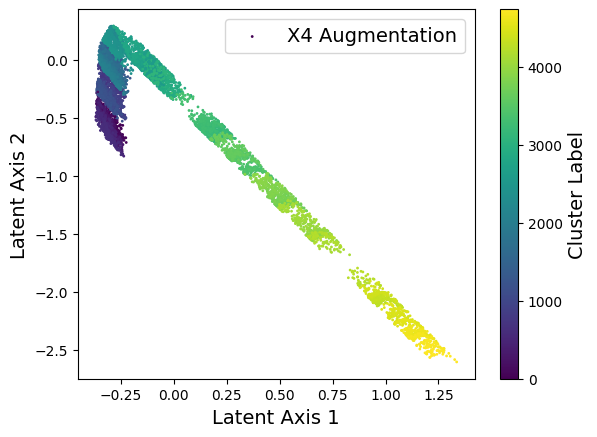

In [ ]:
# latent space distribution
plt.scatter(latent[:,0], latent[:,1], s = 1, c = labels, cmap='viridis',label = 'X4 Augmentation')
cbar = plt.colorbar()
cbar.set_label(label = 'Cluster Label',fontsize = 14)
plt.xlabel('Latent Axis 1', fontsize = 14)
plt.ylabel('Latent Axis 2', fontsize = 14)
plt.legend(fontsize = 14)

In [ ]:
#~13min
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score, mutual_info_score

adjusted_rand_score_list, davies_bouldin_score_list, mutual_info_score_list = [], [], []
#Hun code
'''for estimated_labels, ground_truth_labels in zip(estimated_label_list, ground_truth_label_list):
    adjusted_rand_score_list.append(
        adjusted_rand_score(estimated_labels.squeeze(1), ground_truth_labels.squeeze(1)) * len(estimated_labels)
    )
    davies_bouldin_score_list.append(
        davies_bouldin_score(estimated_labels, ground_truth_labels) * len(estimated_labels)
    )
    mutual_info_score_list.append(
        mutual_info_score(estimated_labels.squeeze(1), ground_truth_labels.squeeze(1)) * len(estimated_labels)
    )'''
#gpt code
for estimated_labels, ground_truth_labels in tqdm(zip(estimated_label_list, ground_truth_label_list),'evaluation'):
    # Ensure the labels are 1-dimensional
    estimated_labels = estimated_labels.squeeze()
    ground_truth_labels = ground_truth_labels.squeeze()

    # Compute adjusted rand score
    adjusted_rand_score_list.append(
        adjusted_rand_score(estimated_labels, ground_truth_labels) * len(estimated_labels)
    )

    # Compute mutual info score
    mutual_info_score_list.append(
        mutual_info_score(estimated_labels, ground_truth_labels)
    )

    # Reshape estimated_labels to 2D array for davies_bouldin_score
    estimated_labels_reshaped = estimated_labels.reshape(-1, 1)

    # Compute davies_bouldin_score
    davies_bouldin_score_list.append(
        davies_bouldin_score(estimated_labels_reshaped, ground_truth_labels)
    )

total_num_samples = np.sum(num_test_samples_list)
total_test_loss = np.sum(total_test_loss_list) /total_num_samples
total_adjusted_rand_score = np.sum(adjusted_rand_score_list) / total_num_samples
total_davies_bouldin_score = np.sum(davies_bouldin_score_list) / total_num_samples
total_mutual_info_score = np.sum(mutual_info_score_list) / total_num_samples
print(f"{total_num_samples=} {total_test_loss=} {total_adjusted_rand_score=} {total_davies_bouldin_score=} {total_mutual_info_score=}")

evaluation: 500it [13:37,  1.64s/it]

total_num_samples=4709379 total_test_loss=5.111066607494192e-06 total_adjusted_rand_score=0.033668086345455685 total_davies_bouldin_score=0.030164765599179345 total_mutual_info_score=0.0004398728308905282


4709379


(array([  4.,  11.,  30.,  52.,  86., 105.,  88.,  76.,  26.,  22.]),
 array([3.26108932, 3.41739612, 3.57370291, 3.73000971, 3.88631651,
        4.0426233 , 4.1989301 , 4.3552369 , 4.51154369, 4.66785049,
        4.82415729]),
 <BarContainer object of 10 artists>)

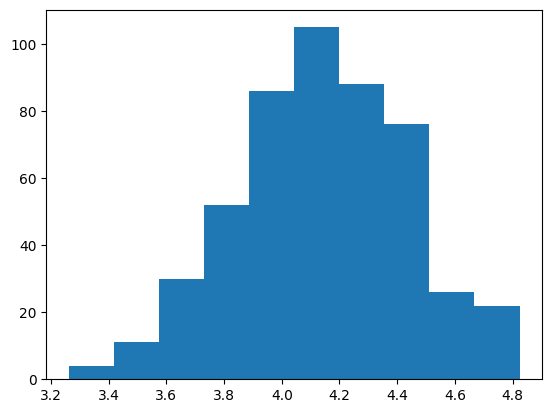

In [ ]:
print(total_num_samples)
plt.hist(mutual_info_score_list)


8957
[ 0.00434029 -0.0302215 ]
[0.00051912 0.00035947]
0.00023633314204042947


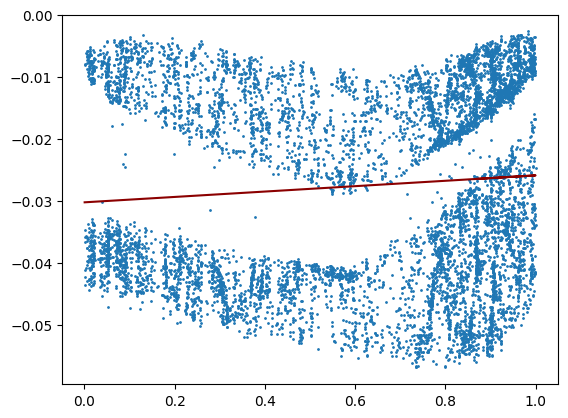

In [ ]:
#dists.detach().cpu().numpy().squeeze()
#from the last test set data
from scipy.optimize import curve_fit

z_out.detach().cpu().numpy().squeeze()
plt.scatter(dists.detach().cpu().numpy().squeeze(), z_out.detach().cpu().numpy().squeeze(),s = 1)

def linear_model(x, a, b):
    return a * x + b

params, params_covariance = curve_fit(linear_model, dists.detach().cpu().numpy().squeeze(), z_out.detach().cpu().numpy().squeeze())
params_err = np.sqrt(np.diag(params_covariance))
y_fit = linear_model(dists.detach().cpu().numpy().squeeze(), *params)
chi_square = np.sum(((z_out.detach().cpu().numpy().squeeze() - y_fit))**2)
dof = len(z_out.detach().cpu().numpy().squeeze()) - len(params)
plt.plot(dists.detach().cpu().numpy().squeeze(), y_fit,color ='darkred')
reduced_chi_square = chi_square / dof

print(len(dists.detach().cpu().numpy().squeeze()))
print(params)
print(params_err)
print(reduced_chi_square)


In [ ]:
#Comparing with the initial data
from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer()
train_input_test, _, train_dist_test = load_pkl_dir_list([test_pkl_dir_list[-1]])
train_input_test[0][0]

(23.071622546518526,
 -24.611120891190254,
 1458.527362700127,
 11.972257873192662)

In [ ]:
print(len(train_dist_test[0]))
print(len(train_input_test[0]))

8957
8957


In [ ]:
from astropy.cosmology import LambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import Distance

#cos = LambdaCDM(H0=72, Om0=0.26, Ode0=0.74)
z_test = np.array([train_input_test[0][i][2] for i in range(len(train_input_test[0]))])
#dist_from_z_test = np.array([cos.comoving_distance(z).to(u.Mpc).value for z in z_test])
z_test

array([1458.5273627 , 1460.16750929, 1456.10049153, ...,  145.0981358 ,
        144.92352423,  124.08126052])

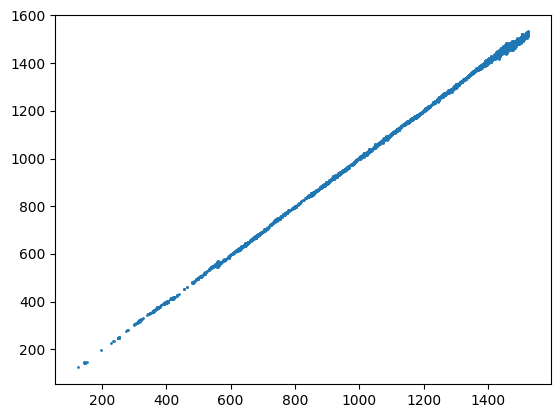

In [ ]:
h = 0.72
plt.scatter(train_dist_test[0]/h,z_test,s = 1)

In [ ]:
dist_from_z_test_reshaped = z_test.reshape(-1, 1)
train_dist_test_reshaped = (train_dist_test[0]/h).reshape(-1, 1)

# Transform the reshaped arrays
norm_train_dist_test = dist_normalizer.transform(train_dist_test_reshaped)
norm_dist_from_z_test = dist_normalizer.transform(dist_from_z_test_reshaped)

In [ ]:
dist_from_z_test_reshaped

array([[1458.5273627 ],
       [1460.16750929],
       [1456.10049153],
       ...,
       [ 145.0981358 ],
       [ 144.92352423],
       [ 124.08126052]])

8957
[ 1.00312596 -0.00280221]
[1.04369151e-04 9.38025646e-05]
7.868061736092255e-06


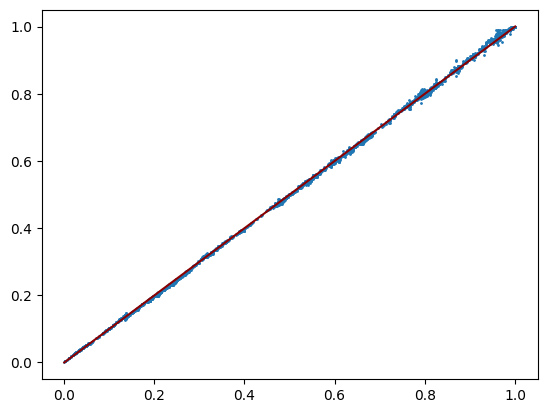

In [ ]:
plt.scatter(norm_train_dist_test.squeeze(),norm_dist_from_z_test.squeeze(),s = 1)

def linear_model(x, a, b):
    return a * x + b

params, params_covariance = curve_fit(linear_model, norm_train_dist_test.squeeze(), norm_dist_from_z_test.squeeze())
params_err = np.sqrt(np.diag(params_covariance))
y_fit = linear_model(norm_train_dist_test.squeeze(), *params)
plt.plot()
chi_square = np.sum(((norm_dist_from_z_test.squeeze() - y_fit))**2)
dof = len(norm_dist_from_z_test.squeeze()) - len(params)
plt.plot(norm_train_dist_test.squeeze(), y_fit,color ='darkred')
reduced_chi_square = chi_square / dof

print(len(norm_train_dist_test.squeeze()))
print(params)
print(params_err)
print(reduced_chi_square)

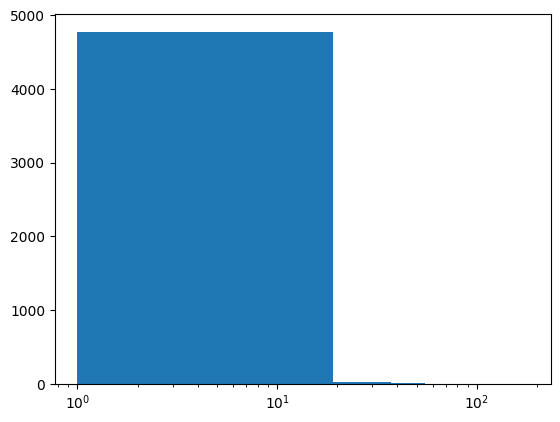

In [ ]:
cng = np.array([len(labels[labels==i]) for i in range(int(max(labels)))])
plt.hist(cng)
plt.xscale('log')

In [ ]:
print(len(cng[cng>5]))
print(len(cng))
print(len(labels))

177
4806
8957


In [ ]:
np.where(cng>5)

(array([  18,   45,   52,   54,   56,   70,   86,  103,  112,  132,  139,
         150,  152,  162,  170,  181,  197,  198,  200,  205,  230,  236,
         267,  277,  306,  309,  319,  324,  357,  378,  407,  435,  477,
         490,  492,  494,  514,  535,  543,  564,  565,  567,  607,  621,
         635,  677,  689,  727,  754,  760,  768,  771,  777,  779,  786,
         794,  800,  804,  821,  833,  870,  883,  910,  929,  962,  964,
         989,  993,  996, 1003, 1029, 1036, 1046, 1058, 1069, 1159, 1160,
        1175, 1197, 1240, 1245, 1256, 1265, 1291, 1302, 1324, 1334, 1343,
        1348, 1355, 1356, 1372, 1373, 1396, 1399, 1409, 1463, 1490, 1517,
        1524, 1590, 1594, 1603, 1690, 1736, 1789, 1796, 1806, 1814, 1884,
        1906, 1912, 1922, 1924, 1930, 1931, 1935, 1945, 2062, 2104, 2192,
        2276, 2311, 2321, 2327, 2356, 2386, 2425, 2427, 2450, 2586, 2676,
        2900, 3015, 3083, 3150, 3209, 3296, 3311, 3371, 3394, 3422, 3423,
        3445, 3447, 3457, 3561, 3664, 

In [ ]:
print(latent[:,0][labels.squeeze() == 4634])
print(latent[:,1][labels.squeeze() == 4631])
print(list(zip(latent[:,0][labels.squeeze() == 4631],latent[:,1][labels.squeeze() == 4631])))

[-0.05747727 -0.06090945]
[0.34696162 0.35170534]
[(-0.05682065, 0.34696162), (-0.08060384, 0.35170534)]


Text(0, 0.5, 'Latent Axis 2')

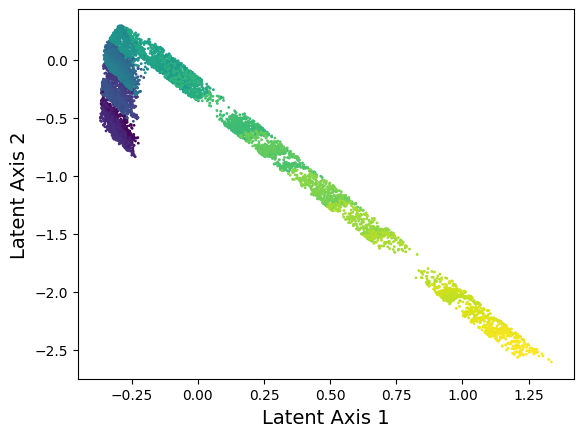

In [ ]:
plt.scatter(latent[:,0], latent[:,1], s = 1, c = labels, cmap='viridis')
plt.xlabel('Latent Axis 1', fontsize = 14)
plt.ylabel('Latent Axis 2', fontsize = 14)
#plt.scatter(latent[:,0][labels.squeeze() == 4631], latent[:,1][labels.squeeze() == 4631], s = 1)#, c = labels, cmap='viridis')
#plt.scatter(latent[:,0][(labels > 10) & (labels < 15)], latent[:,1][(labels > 10) & (labels < 15)],
#            c = labels[(labels > 10) & (labels < 15)],cmap = 'viridis', s = 1)

In [ ]:
Ncl = []
files = glob.glob("/content/drive/MyDrive/SNU/research_2024/ML/data/*")

for i in files[1:2]:
    with open(i, 'rb') as file:
    # Use pickle.load() to deserialize and load the list
        loaded_list = pickle.load(file)

(array([9.351e+03, 5.400e+01, 6.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([2.70611218e+11, 4.39923630e+12, 8.52786138e+12, 1.26564865e+13,
        1.67851115e+13, 2.09137366e+13, 2.50423617e+13, 2.91709868e+13,
        3.32996119e+13, 3.74282370e+13, 4.15568620e+13]),
 <BarContainer object of 10 artists>)

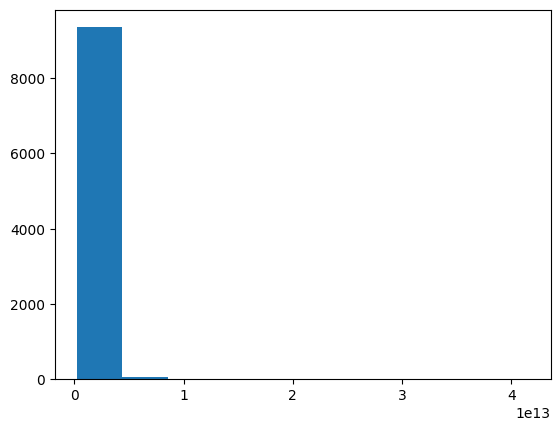

In [ ]:
#plt.scatter(loaded_list[9],loaded_list[11] )
plt.hist(loaded_list[3])

(array([ 10.,  97., 321., 656., 688., 453., 187.,  65.,  18.,   5.]),
 array([3487. , 3875.9, 4264.8, 4653.7, 5042.6, 5431.5, 5820.4, 6209.3,
        6598.2, 6987.1, 7376. ]),
 <BarContainer object of 10 artists>)

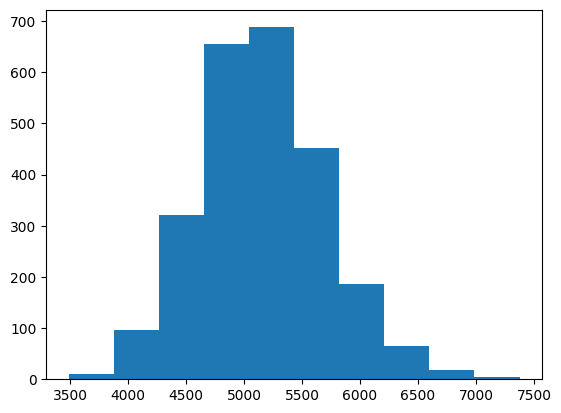

In [ ]:
import glob

Ncl = []
files = glob.glob("/content/drive/MyDrive/SNU/research_2024/ML/data/*")

for i in files:
    with open(i, 'rb') as file:
    # Use pickle.load() to deserialize and load the list
        loaded_list = pickle.load(file)
    Ncl.append(loaded_list[-4])

plt.hist(Ncl)

0.0039687157


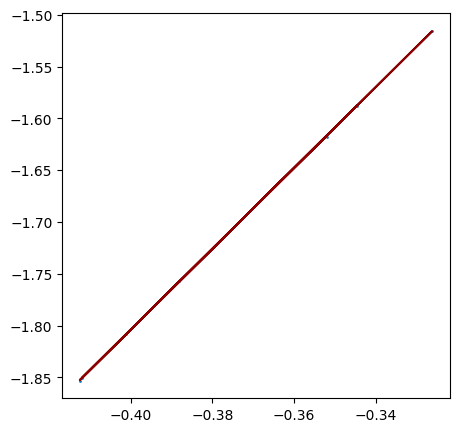

In [ ]:
#old result check
plt.subplots(figsize = (5,5))
#plt.scatter(latent[:,0], latent[:,1], c = labels, s = 1, cmap='viridis')
plt.scatter(latent[:,0][labels == 4689], latent[:,1][labels == 4689], s = 1)
#plt.scatter(latent[:,0][(labels > 100) & (labels < 105)], latent[:,1][(labels > 100) & (labels < 105)],
#            c = labels[(labels > 100) & (labels < 105)],cmap = 'viridis', s = 1)

x_cl = latent[:,0][labels == 4689]
y_cl = latent[:,1][labels == 4689]

params, params_covariance = curve_fit(linear_model, x_cl,y_cl)
params_err = np.sqrt(np.diag(params_covariance))
y_fit = linear_model(x_cl, *params)

chi_square = np.sum(((y_cl - y_fit))**2)
#dof = len(norm_dist_from_z_test.squeeze()) - len(params)
plt.plot(x_cl, y_fit,color ='darkred')
reduced_chi_square = chi_square / dof
print(np.sum(np.abs(y_cl - y_fit)))
#print(len(norm_train_dist_test.squeeze()))
#print(params)
#print(params_err)
#print(reduced_chi_square)

NameError: name 'curve_fit' is not defined

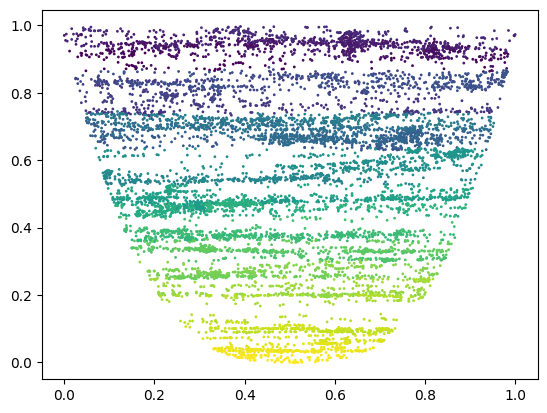

In [ ]:
plt.scatter(inputs[:,1].detach().cpu().numpy(),inputs[:,2].detach().cpu().numpy(), c = labels, s = 1)
#plt.scatter(inputs[:,1].detach().cpu().numpy()[labels.squeeze() == 4631],inputs[:,2].detach().cpu().numpy()[labels.squeeze() == 4631], s = 1)
#plt.scatter(inputs[:,1].detach().cpu().numpy()[(labels > 100) & (labels < 105)], inputs[:,2].detach().cpu().numpy()[(labels > 100) & (labels < 105)],
#            c = labels[(labels > 100) & (labels < 105)],cmap = 'viridis', s = 5)

x_cl = inputs[:,1].detach().cpu().numpy()[labels.squeeze() == 4631]
y_cl = inputs[:,2].detach().cpu().numpy()[labels.squeeze() == 4631]

params, params_covariance = curve_fit(linear_model, x_cl,y_cl)
params_err = np.sqrt(np.diag(params_covariance))
y_fit = linear_model(x_cl, *params)
plt.plot(x_cl, y_fit,color ='darkred')
reduced_chi_square = chi_square / dof
print(np.sum(np.abs(y_cl - y_fit)))

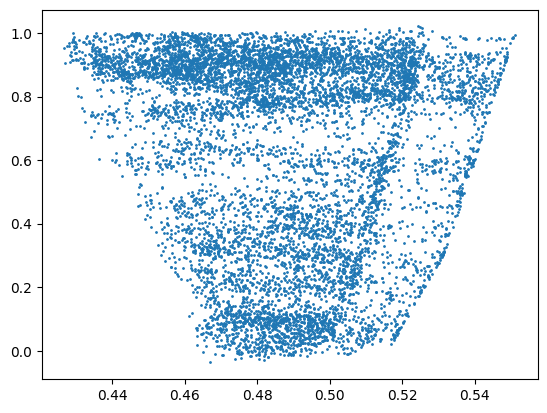

In [ ]:
#plt.scatter(recon_out[:,1].detach().cpu().numpy()[labels == 4689],recon_out[:,2].detach().cpu().numpy()[labels == 4689], s = 1)
plt.scatter(recon_out[:,1].detach().cpu().numpy(),recon_out[:,2].detach().cpu().numpy(), s = 1)


In [ ]:
recon_out

tensor([[0.8074, 0.5064, 0.8855, 0.4151],
        [0.7984, 0.5068, 0.9218, 0.4231],
        [0.8439, 0.5058, 0.8855, 0.3816],
        ...,
        [0.8498, 0.4985, 0.0019, 0.3819],
        [0.8085, 0.4992, 0.0035, 0.4199],
        [0.2525, 0.5038, 0.0034, 0.8050]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
# Data augmentation
import glob

files = glob.glob(dataset_root_dir + '/*')

for filename in tqdm(files,desc = 'running'):
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    #print(len(loaded_list))

    data  = [loaded_list[0], loaded_list[1], loaded_list[2], loaded_list[3], loaded_list[4],
            loaded_list[5], loaded_list[6], loaded_list[7], loaded_list[8], loaded_list[9], loaded_list[10], loaded_list[11]]
    data1 = [loaded_list[0], loaded_list[1], loaded_list[2], loaded_list[3], loaded_list[4],
            loaded_list[5], loaded_list[6], loaded_list[7], loaded_list[8], list(-1*np.array(loaded_list[9])), loaded_list[10], loaded_list[11]]
    data2 = [loaded_list[0], loaded_list[1], loaded_list[2], loaded_list[3], loaded_list[4],
            loaded_list[5], loaded_list[6], loaded_list[7], loaded_list[8], loaded_list[9], list(-1*np.array(loaded_list[10])),  loaded_list[11]]
    data3 = [loaded_list[0], loaded_list[1], loaded_list[2], loaded_list[3], loaded_list[4],
            loaded_list[5], loaded_list[6], loaded_list[7], loaded_list[8], list(-1*np.array(loaded_list[9])), list(-1*np.array(loaded_list[10])),  loaded_list[11]]

    with open(dataset_aug_dir + '/' + filename.split('/')[-1], 'wb') as file:
        # Use pickle.load() to deserialize and load the list
        pickle.dump(data, file)
    with open(dataset_aug_dir + '/aug1_' + filename.split('/')[-1], 'wb') as file:
        # Use pickle.load() to deserialize and load the list
        pickle.dump(data1, file)
    with open(dataset_aug_dir + '/aug2_' + filename.split('/')[-1], 'wb') as file:
        # Use pickle.load() to deserialize and load the list
        pickle.dump(data2, file)
    with open(dataset_aug_dir + '/aug3_' + filename.split('/')[-1], 'wb') as file:
        # Use pickle.load() to deserialize and load the list
        pickle.dump(data3, file)

running: 100%|██████████| 2500/2500 [35:53<00:00,  1.16it/s]


In [ ]:
with open(output_save_dir+'/loss_history_ra_dec_z.pkl', 'rb') as file:
  loaded_list = pickle.load(file)

Text(0, 0.5, 'Loss')

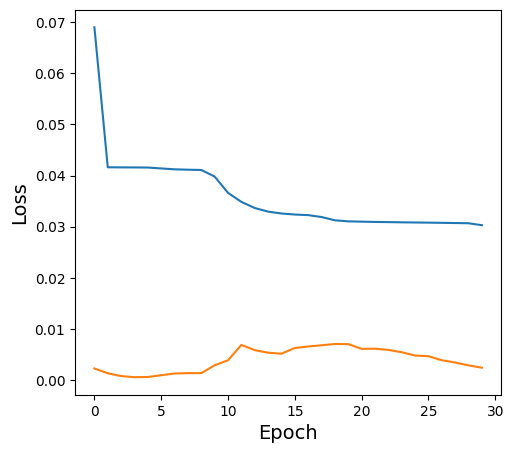

In [ ]:
plt.subplots(figsize = (5.5,5))
plt.plot(range(len(loaded_list[0])), loaded_list[0])
plt.plot(range(len(loaded_list[1])), 100*np.array(loaded_list[1]))
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
#plt.legend(['Training', '100*Validation'],fontsize = 14)
